# 项目：用线性回归预测房价数据

## 分析目标

此数据分析报告的目的是，基于已有的房屋销售价格，以及有关该房屋的属性，进行线性回归分析，从而利用得到的线性回归模型，能对以下未知售价的房屋根据属性进行价格预测：

面积为6500平方英尺，有4个卧室、2个厕所，总共2层，不位于主路，无客人房，带地下室，有热水器，没有空调，车位数为2，位于城市首选社区，简装修。

## 简介

数据集`house_price.csv`记录了超过五百栋房屋的交易价格，以及房屋的相关属性信息，包括房屋面积、卧室数、厕所数、楼层数、是否位于主路、是否有客房，等等。

`house_price.csv`每列的含义如下：
- price：房屋出售价格
- area：房屋面积，以平方英尺为单位
- bedrooms：卧室数
- bathrooms：厕所数
- stories：楼层数
- mainroad：是否位于主路
   - yes  是
   - no	  否
- guestroom：是否有客房
   - yes  是
   - no	  否
- basement：是否有地下室
   - yes  是
   - no	  否
- hotwaterheating：是否有热水器
   - yes  是
   - no	  否
- airconditioning：是否有空调
   - yes  是
   - no	  否
- parking：车库容量，以车辆数量为单位
- prefarea：是否位于城市首选社区
   - yes  是
   - no	  否
- furnishingstatus：装修状态
   - furnished       精装
   - semi-furnished	 简装
   - unfurnished     毛坯

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
import statsmodels.api as sm

In [5]:
from scipy.stats import ttest_ind

### 读取数据

In [6]:
original_data = pd.read_csv('house_price.csv')
original_data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


### 清洗数据

In [7]:
cleaned_data = original_data.copy()

In [8]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


数据不存在空值，'mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea','furnishingstatus'作为分类数据需要将数据类型object类型转换为category类型。

In [9]:
cleaned_data['mainroad'] = cleaned_data['mainroad'].astype('category')
cleaned_data['guestroom'] = cleaned_data['guestroom'].astype('category')
cleaned_data['basement'] = cleaned_data['basement'].astype('category')
cleaned_data['hotwaterheating'] = cleaned_data['hotwaterheating'].astype('category')
cleaned_data['airconditioning'] = cleaned_data['airconditioning'].astype('category')
cleaned_data['prefarea'] = cleaned_data['prefarea'].astype('category')
cleaned_data['furnishingstatus'] = cleaned_data['furnishingstatus'].astype('category')

In [10]:
cleaned_data[['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']].value_counts()

mainroad  guestroom  basement  hotwaterheating  airconditioning  prefarea
yes       no         no        no               no               no          151
                                                yes              no           62
                     yes       no               no               no           43
no        no         no        no               no               no           42
yes       no         no        no               no               yes          32
                     yes       no               no               yes          21
          yes        yes       no               no               no           20
          no         yes       no               yes              no           19
          yes        yes       no               no               yes          18
          no         no        no               yes              yes          18
                     yes       no               yes              yes          15
          yes        yes       no  

In [11]:
cleaned_data['furnishingstatus'].value_counts()

furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64

In [12]:
cleaned_data.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


根据以上列表，数据在结构上和内容上都符合分析所需的数据标准。

### 可视化分析

In [13]:
sns.set_palette('pastel')

#### 装修类型占比图

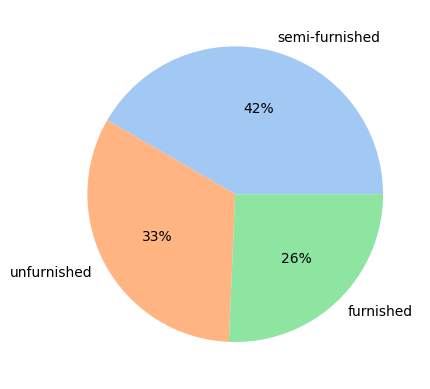

In [14]:
furnishingstatus_count = cleaned_data['furnishingstatus'].value_counts()
plt.pie(furnishingstatus_count,autopct = '%.0f%%',labels = furnishingstatus_count.index)
plt.show()

根据图表，数据中简装修房屋的占比最多；精装修房屋的占比最少。

#### 房价分布图

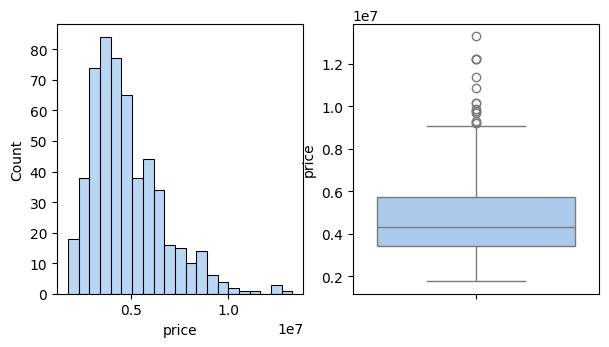

In [15]:
fig,axes = plt.subplots(1,2,figsize=(7,3.5))
sns.histplot(cleaned_data,x='price',ax=axes[0])
sns.boxplot(cleaned_data,y='price',ax=axes[1])
plt.show()

根据上图，可以看出房价呈右偏态分布。受高房价的极端值影响，拉高了平均值。

#### 房屋面积分布图

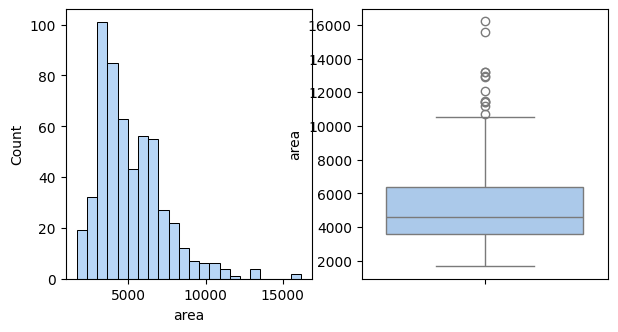

In [16]:
fig,axes = plt.subplots(1,2,figsize=(7,3.5))
sns.histplot(cleaned_data,x='area',ax=axes[0])
sns.boxplot(cleaned_data,y='area',ax=axes[1])
plt.show()

房屋面积和房价所表现的数据类型十分相似，也受到了高极端值的影响从而拉高了平均面积。

#### 房价与面积关系图

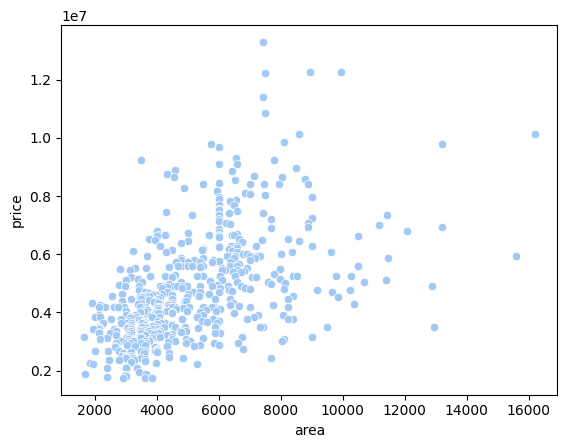

In [17]:
sns.scatterplot(cleaned_data,x='area',y='price')
plt.show()

房价与面积大致上呈正相关趋势。

#### 卧室数量与价格关系图

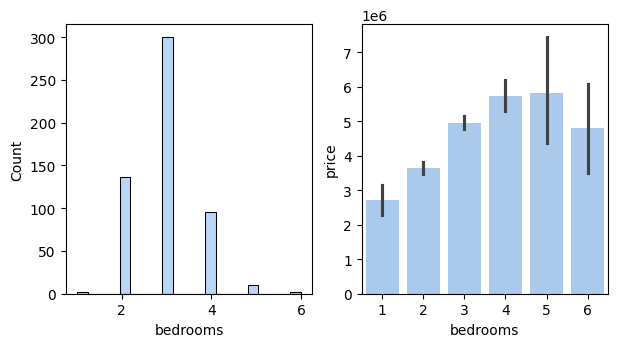

In [18]:
fig,axes=plt.subplots(1,2,figsize=(7,3.5))
sns.histplot(cleaned_data,x='bedrooms' , ax=axes[0])
sns.barplot(cleaned_data, x='bedrooms' ,y='price' ,ax=axes[1])
plt.show()

根据上图，3间卧室的房子数量最多。卧室数量在5个以下时，卧室数与价格呈正相关关系，超过5个时价格反而有所下降。

#### 装修状态与价格关系图

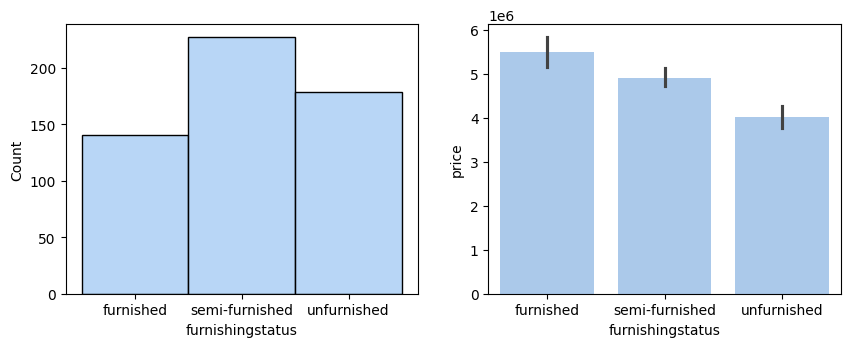

In [19]:
fig,axes=plt.subplots(1,2,figsize=(10,3.5))
sns.histplot(cleaned_data,x='furnishingstatus' , ax=axes[0])
sns.barplot(cleaned_data, x='furnishingstatus' ,y='price' ,ax=axes[1])
plt.show()

根据上图可以看到，简装修的房屋数量最多，精装修的房屋价格最贵。

### 数据整理

In [20]:
cleaned_data = pd.get_dummies(cleaned_data,columns=
                              ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea','furnishingstatus'],
                              dtype=int,drop_first=True)
cleaned_data

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,2,1,0,0,0,1,1,0,0
1,12250000,8960,4,4,4,3,1,0,0,0,1,0,0,0
2,12250000,9960,3,2,2,2,1,0,1,0,0,1,1,0
3,12215000,7500,4,2,2,3,1,0,1,0,1,1,0,0
4,11410000,7420,4,1,2,2,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,2,1,0,1,0,0,0,0,1
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1,0
542,1750000,3620,2,1,1,0,1,0,0,0,0,0,0,1
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,0,0


### 线性回归分析

In [21]:
analyse_data = cleaned_data.copy()

In [22]:
y=analyse_data['price']

In [23]:
x=analyse_data.drop('price',axis=1)

In [24]:
(x.corr().abs()>0.8)

,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
area,True,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False
stories,False,False,False,True,False,False,False,False,False,False,False,False,False
parking,False,False,False,False,True,False,False,False,False,False,False,False,False
mainroad_yes,False,False,False,False,False,True,False,False,False,False,False,False,False
guestroom_yes,False,False,False,False,False,False,True,False,False,False,False,False,False
basement_yes,False,False,False,False,False,False,False,True,False,False,False,False,False
hotwaterheating_yes,False,False,False,False,False,False,False,False,True,False,False,False,False
airconditioning_yes,False,False,False,False,False,False,False,False,False,True,False,False,False


可以看到不同变量之间的相关系数都小于0.8，降低了模型出现共线性的可能性。

In [25]:
x = sm.add_constant(x)

In [26]:
result = sm.OLS(y,x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     87.52
Date:                Sun, 18 Aug 2024   Prob (F-statistic):          9.07e-123
Time:                        23:29:30   Log-Likelihood:                -8331.5
No. Observations:                 545   AIC:                         1.669e+04
Df Residuals:                     531   BIC:                         1.675e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            4.277e+04   2.64e+05      0.162      0.872   -4.76e+05    5.62e+05
area                              244.1394     24.289     10.052      0.000     196.425     291.853
bedrooms                         1.148e+05   7.26e+04      1.581      0.114   -2.78e+04    2.57e+05
bathrooms                        9.877e+05   1.03e+05      9.555      0.000    7.85e+05    1.19e+06
stories                          4.508e+05   6.42e+04      7.026      0.000    3.25e+05    5.77e+05
parking                          2.771e+05   5.85e+04      4.735      0.000    1.62e+05    3.92e+05
mainroad_yes                     4.213e+05   1.42e+05      2.962      0.003    1.42e+05    7.01e+05
guestroom_yes                    3.005e+05   1.32e+05      2.282      0.023    4.18e+04    5.59e+05
basement_yes                     3.501e+05    1.1e+05      3.175      0.002    1.33e+05    5.67e+05
hotwaterheating_yes              8.554e+05   2.23e+05      3.833      0.000    4.17e+05    1.29e+06
airconditioning_yes               8.65e+05   1.08e+05      7.983      0.000    6.52e+05    1.08e+06
prefarea_yes                     6.515e+05   1.16e+05      5.632      0.000    4.24e+05    8.79e+05
furnishingstatus_semi-furnished -4.634e+04   1.17e+05     -0.398      0.691   -2.75e+05    1.83e+05
furnishingstatus_unfurnished    -4.112e+05   1.26e+05     -3.258      0.001   -6.59e+05   -1.63e+05
==============================================================================
Omnibus:                       97.909   Durbin-Watson:                   1.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.281
Skew:                           0.895   Prob(JB):                     8.22e-57
Kurtosis:                       5.859   Cond. No.                     3.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

根据结果可以看到，const、bedrooms、furnishingstatus_semi-furnished的p值都大于5%的显著性水平，对房价的影响较小，应当删除。

In [27]:
x = x.drop(['const','bedrooms','furnishingstatus_semi-furnished'],axis=1)

In [28]:
result = sm.OLS(y,x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              1088.
Date:                Sun, 18 Aug 2024   Prob (F-statistic):                        0.00
Time:                        23:29:30   Log-Likelihood:                         -8333.5
No. Observations:                 545   AIC:                                  1.669e+04
Df Residuals:                     534   BIC:                                  1.674e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
area                           257.5854     22.577     11.409      0.000     213.234     301.936
bathrooms                     1.071e+06   9.27e+04     11.553      0.000    8.89e+05    1.25e+06
stories                       5.084e+05   5.71e+04      8.898      0.000    3.96e+05    6.21e+05
parking                       2.793e+05   5.83e+04      4.794      0.000    1.65e+05    3.94e+05
mainroad_yes                  4.672e+05   1.27e+05      3.679      0.000    2.18e+05    7.17e+05
guestroom_yes                 2.851e+05   1.31e+05      2.172      0.030    2.72e+04    5.43e+05
basement_yes                  4.016e+05   1.07e+05      3.765      0.000    1.92e+05    6.11e+05
hotwaterheating_yes           8.668e+05   2.23e+05      3.884      0.000    4.28e+05    1.31e+06
airconditioning_yes           8.543e+05   1.07e+05      7.952      0.000    6.43e+05    1.07e+06
prefarea_yes                  6.443e+05   1.15e+05      5.594      0.000    4.18e+05    8.71e+05
furnishingstatus_unfurnished -3.493e+05   9.49e+04     -3.679      0.000   -5.36e+05   -1.63e+05
==============================================================================
Omnibus:                       94.840   Durbin-Watson:                   1.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              251.889
Skew:                           0.865   Prob(JB):                     2.01e-55
Kurtosis:                       5.845   Cond. No.                     2.74e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

可以看到，模型拟合的很好。根据模型，面积、卧室数、厕所数、楼层、位于主路、有客人房、有地下室、有热水器、有空调、车位数，位于城市首选社区
都能显著提升房价；装修状态为毛坯房能显著降低房价。

### 房价预测

In [29]:
predicted_data = pd.DataFrame({'area':[6500],'bedrooms':[4],'bathrooms':[2],'stories':[2],'mainroad':['no'],'guestroom':['no'],'basement':['yes'],
                             'hotwaterheating':['yes'],'airconditioning':['no'],'parking':[2],'prefarea':['yes'],
                               'furnishingstatus':['no'] })
predicted_data

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,6500,4,2,2,no,no,yes,yes,no,2,yes,no


In [30]:
predicted_data['mainroad'] = pd.Categorical(predicted_data['mainroad'],categories=['no','yes'])
predicted_data['guestroom'] = pd.Categorical(predicted_data['guestroom'],categories=['no','yes'])
predicted_data['basement'] = pd.Categorical(predicted_data['basement'],categories=['no','yes'])
predicted_data['hotwaterheating'] = pd.Categorical(predicted_data['hotwaterheating'],categories=['no','yes'])
predicted_data['airconditioning'] = pd.Categorical(predicted_data['airconditioning'],categories=['no','yes'])
predicted_data['prefarea'] = pd.Categorical(predicted_data['prefarea'],categories=['no','yes'])
predicted_data['furnishingstatus'] = pd.Categorical(predicted_data['furnishingstatus'],categories=['unfurnished','semi-furnished','furnished'])

In [31]:
predicted_data = pd.get_dummies(predicted_data,columns=
                              ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea','furnishingstatus'],
                              dtype=int,drop_first=True)

In [32]:
predicted_data = predicted_data.drop(['bedrooms','furnishingstatus_semi-furnished'],axis=1)

In [33]:
predicted_data = result.predict(predicted_data)
predicted_data

0    7.303754e+06
dtype: float64

面积为6500平方英尺，有4个卧室、2个厕所，总共2层，不位于主路，无客人房，带地下室，有热水器，没有空调，车位数为2，位于城市首选社区，简装修的房子线性回归模型预测价格为7303754